### migraine

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
from subject_select import restrict_pain_to_disease, check_count, check_field

In [3]:
df = pd.read_csv('./data/qsidp_patients_pain.csv')

/home/fs0/syzhang/.conda/envs/bbk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# migraine, 3+m headache or facial pain
df_rp0 = restrict_pain_to_disease(df, disease_code=1265, cwp_code=[3799, 4067, 3404]) 

In [5]:
df_rp0.shape

(539, 2861)

In [6]:
# Degree bothered by headaches in the last 3 months,21051
cols_ls = check_field(df_rp0, 21051, visit=0)
# df_np = check_count(df, cols_ls, -7)

In [7]:
cols_ls

['21051-0.0']

In [8]:
df_rp0['21051-0.0'].value_counts()

-602.0    199
-601.0    180
-600.0     43
Name: 21051-0.0, dtype: int64

In [ ]:
# -600	Not bothered at all
# -601	Bothered a little
# -602	Bothered a lot
# -818	Prefer not to answer

#### make labels (bothered a lot = 1, bothered a little = 0)

In [9]:
from clean_questions import basic_classify

In [10]:
dfm = df_rp0[df_rp0['21051-0.0']!=-600].dropna(subset=['21051-0.0'])
print(dfm.shape)

(379, 2861)


In [11]:
# making labels for above
label = []
for i,r in dfm.iterrows():
    if r['21051-0.0'] == -602.:
        label.append('severe')
    elif r['21051-0.0'] == -601.:
        label.append('mild')
dfm['label'] = label

In [12]:
dfm['label'].value_counts()

severe    199
mild      180
Name: label, dtype: int64

In [13]:
# code label to binary
lab = dfm['label']=='severe'
label = lab.astype(int)
dfm['label'] = label

In [14]:
dfm['label'].value_counts()

1    199
0    180
Name: label, dtype: int64

#### simple classification of bothered a little / bothred a lot

In [23]:
from clean_questions import load_qscode, extract_qs, impute_qs
questionnaire = 'all'
idp = 'all'
question_visits = [2]
# load question code
qs = load_qscode(questionnaire=questionnaire, idp=idp)
# extract questionnaire of interest
df_qs = extract_qs(dfm, df_questionnaire=qs, visits=question_visits)

In [24]:
df_qs.shape

(379, 1028)

In [25]:
df_qs['label'] = label

In [26]:
# impute
dff_imputed = impute_qs(df_qs, freq_fill='median', nan_percent=0.9, transform=False)

In [27]:
dff_imputed.shape

(379, 968)

Classification report for classifier RandomForestClassifier(max_depth=5):
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        90
           1       0.54      0.71      0.61       100

    accuracy                           0.53       190
   macro avg       0.52      0.52      0.50       190
weighted avg       0.52      0.53      0.51       190

ROC AUC=0.5391, train accuracy=1.0000, test accuracy=0.5263


(0.5391111111111112, 1.0, 0.5263157894736842)

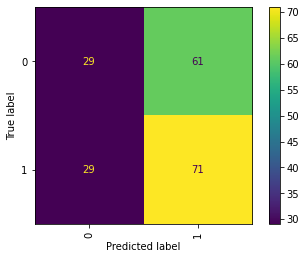

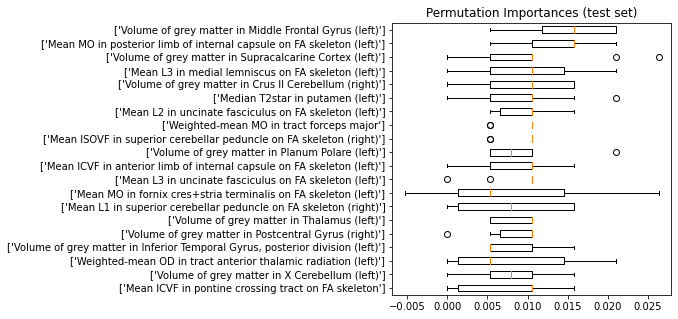

In [27]:
basic_classify(dff_imputed, classifier='rforest', 
               test_size=0.5, random_state=42, 
               plot_figs=True, save_plot=True, 
               save_name='migraine', num_importance=20, 
               questionnaire='all', idp='all', scaler=True, balance=False)

In [43]:
df_res = cv_classify(dff_imputed, classifier='rforest', cv_fold=4, scaler=True, balance=False)

4-fold CV classification with classifier RandomForestClassifier(max_depth=5):
test ROC AUC=0.5456, test accuracy=0.5411, test f1=0.6120


In [46]:
df_res = cv_classify(dff_imputed, classifier='lgb', cv_fold=4, scaler=True, balance=False)

4-fold CV classification with classifier LGBMClassifier():
test ROC AUC=0.5486, test accuracy=0.5383, test f1=0.5797


#### including connectivity

In [33]:
from connectivity_mat import load_connectivity
from clean_questions import cv_classify

In [28]:
dfc = load_connectivity(task_name=None, dff=dff_imputed, 
                       conn_type='fullcorr_100', 
                       add_questionnaire=True, 
                       add_idp=True, 
                       add_conn=True)
print(dfc.shape)

(367, 2453)


In [44]:
df_res = cv_classify(dfc, classifier='rforest', cv_fold=4, scaler=True, balance=True)

4-fold CV classification with classifier RandomForestClassifier(max_depth=5):
test ROC AUC=0.5150, test accuracy=0.5230, test f1=0.5114


In [42]:
df_res = cv_classify(dfc, classifier='rforest', cv_fold=4, scaler=True, balance=False)

4-fold CV classification with classifier RandomForestClassifier(max_depth=5):
test ROC AUC=0.5372, test accuracy=0.5503, test f1=0.6264


In [45]:
df_res = cv_classify(dfc, classifier='lgb', cv_fold=4, scaler=True, balance=False)

4-fold CV classification with classifier LGBMClassifier():
test ROC AUC=0.5067, test accuracy=0.5069, test f1=0.5603


adding connectivity doesn't seem to improve classifer much